Umsetzung des 1. Teils für die Quantum modular exponential Funktion.
Dafür wird eine Addition genutzt deren Implementierung nicht den klassischen Volladdierer übersetzte, da dies 3n Qubits benötigen würde.
Stattdessen wird die Schaltung von https://arxiv.org/pdf/quant-ph/0008033.pdf benutzt. Diese rechnet a+b indem F(a) gebildet wird- dabei ist F(x) die QFT von x, und addiert anschließend F^-1(F(a)+b) wobei F^-1 die inverse QFT ist. Anschließend soll man als Endergebnis a+b erhalten.

In [17]:
import qiskit 
import numpy as np
from qiskit.visualization import plot_histogram

my_gate_names = {
    "displaytext": {
        # gate name : gate text 
        "x": "Pauli X",
        "y": "Pauli Y",
        "z": "Pauli Z",
        "h": "Hadamard",
        "reset": "Reset",
        "id": "Identity",
    },
}

#Ausbaufähig: wenn measurement_qubits nicht von 0 startet, werden die Gatter falsch/gar nicht angewendet.
def myQFT(quantum_circuit, measurement_qubits, inverse = False, swaps = False):
    if not inverse:
        for target in measurement_qubits:
            quantum_circuit.barrier()
            exponent = 2
            quantum_circuit.h(target)
            for control in measurement_qubits[target + 1:]:
                apply_unitary_operator(quantum_circuit, 2 * np.pi, control, target, exponent)
                exponent+=1
        quantum_circuit.barrier()
        if swaps:
            for x in range(0, len(measurement_qubits)//2):
                quantum_circuit.swap(measurement_qubits[x], measurement_qubits[len(measurement_qubits) - 1 - x])
                x+=1
        quantum_circuit.barrier()
    else:
        if swaps:
            quantum_circuit.barrier()
            for x in range(0, len(measurement_qubits)//2):
                quantum_circuit.swap(measurement_qubits[x], measurement_qubits[len(measurement_qubits) - 1 - x])
                x+=1
        for target in reversed(measurement_qubits):
            quantum_circuit.barrier()
            exponent = len(measurement_qubits[target + 1:]) + 1
            for control in reversed(measurement_qubits[target + 1:]):
                apply_unitary_operator(quantum_circuit, -2 * np.pi, control, target, exponent)
                exponent -= 1
            quantum_circuit.h(target)
        quantum_circuit.barrier()

def unitary_operator(theta):
    return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta))).control(1)

def apply_unitary_operator(quantum_circuit, theta, control, target, exponent):
    #Rechne theta * exponent da schneller als exponent-Fache anwendung von U
    quantum_circuit.append(unitary_operator(theta/(2**exponent)),[control, target])

In [31]:
def quantum_Addition(quantum_circuit,Fa,b):
    for target, controlBegin in zip(Fa,range(len(b))):
        exponent = 1
        for control in b[controlBegin:]:
            apply_unitary_operator(quantum_circuit,2 * np.pi, control, target, exponent)
            exponent+=1
        quantum_circuit.barrier()

def apply_quantum_Addition(quantum_circuit,a,b,measure_result = True):
    myQFT(quantum_circuit,a)
    quantum_Addition(quantum_circuit,a,b)
    myQFT(quantum_circuit,a,inverse = True)
    if measure_result:
        quantum_circuit.measure(a,range(len(a)))
        

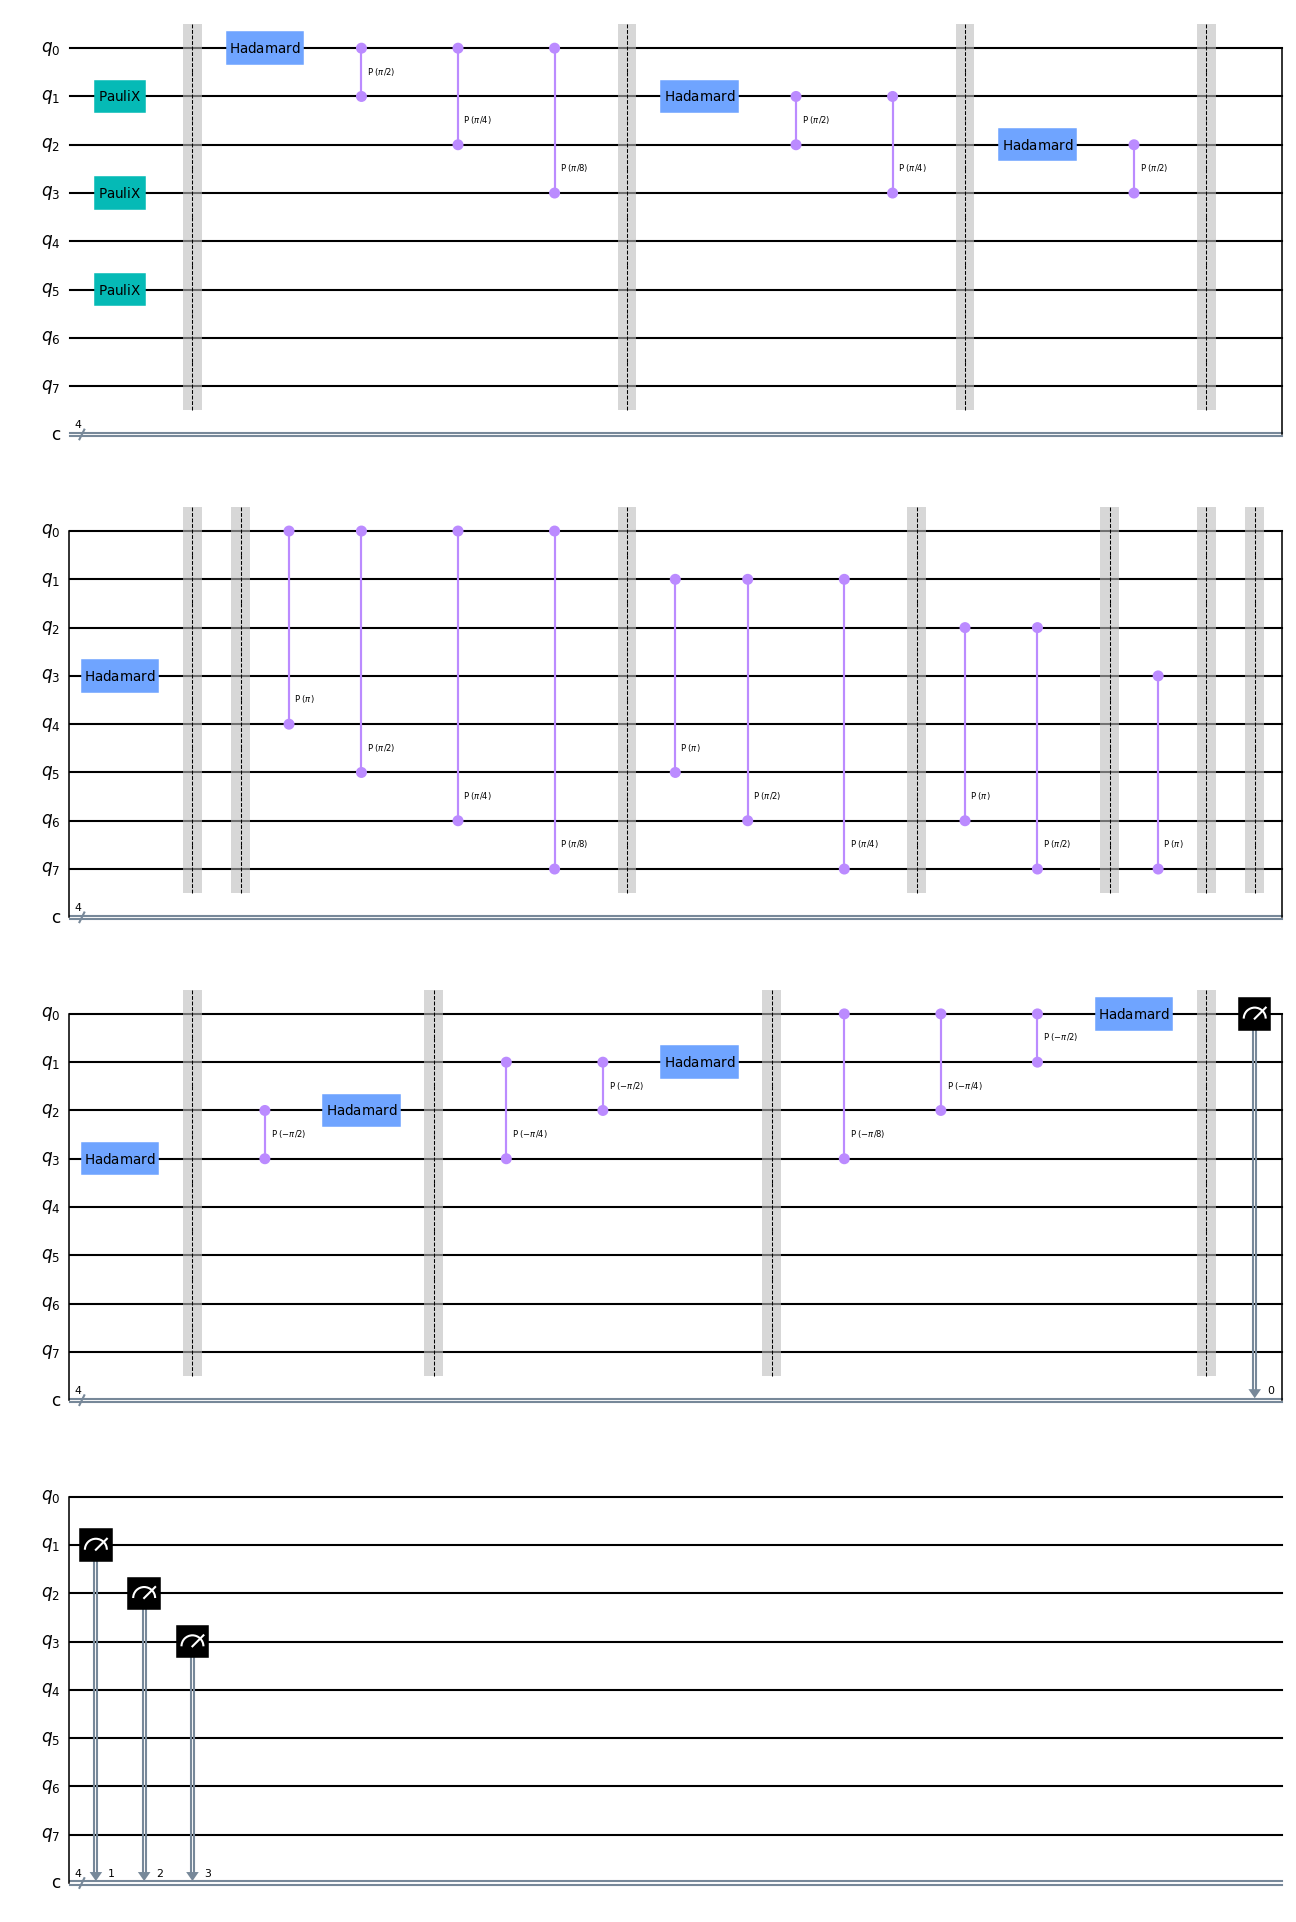

In [32]:
qc = qiskit.QuantumCircuit(8,4)
# q0 ist MSB genau wie das erste qubit von b das MSB ist
# Addiert 5 + 4
qc.x(3)
qc.x(1)
qc.x(5)
apply_quantum_Addition(qc,[0,1,2,3],[4,5,6,7])

qc.draw('mpl', style=my_gate_names, scale = 0.75)

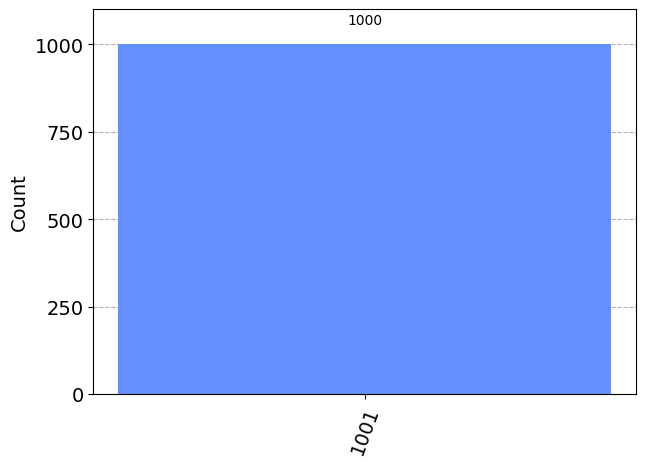

In [33]:
from qiskit import Aer, execute
#simulator = Aer.get_backend('qasm_simulator')
simulator = Aer.get_backend('aer_simulator')
counts = execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

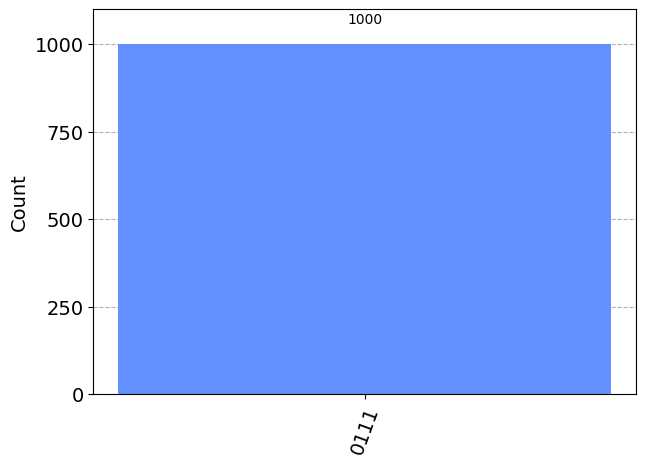

In [34]:
qc = qiskit.QuantumCircuit(8,4)
#Addiert 7 + 7
qc.x(1)
qc.x(2)
qc.x(3)
qc.x(5)
qc.x(6)
qc.x(7)
apply_quantum_Addition(qc,[0,1,2,3],[4,5,6,7])
counts = execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)